# Vehicles and Traffic Signs Detection

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors,preprocess_image, preprocess_image_2, yolo_head
import gradio as gr

%matplotlib inline

In [2]:
import PIL 
print(PIL.__version__)

10.3.0


## Useful functions :

In [3]:

def filter_detections(detection_boxes, confidence_scores, class_probabilities, confidence_threshold=.6):
    """
    Filters detections based on confidence and class probabilities.

    Arguments:
    detection_boxes -- tensor of shape (19, 19, 5, 4)
    confidence_scores -- tensor of shape (19, 19, 5, 1)
    class_probabilities -- tensor of shape (19, 19, 5, 80)
    confidence_threshold -- float, threshold for class probability score

    Returns:
    selected_scores -- tensor of shape (None,), scores of selected detections
    selected_boxes -- tensor of shape (None, 4), coordinates of selected boxes
    selected_classes -- tensor of shape (None,), class indices of selected boxes
    """

    # Calculate the scores for each box
    detection_scores = confidence_scores * class_probabilities

    # Determine the class and score of each box
    detection_classes = tf.math.argmax(detection_scores, axis=-1)
    max_detection_scores = tf.math.reduce_max(detection_scores, axis=-1)

    # Create a mask to filter out boxes below the threshold
    score_mask = max_detection_scores >= confidence_threshold

    # Apply the mask
    filtered_scores = tf.boolean_mask(max_detection_scores, score_mask)
    filtered_boxes = tf.boolean_mask(detection_boxes, score_mask)
    filtered_classes = tf.boolean_mask(detection_classes, score_mask)

    return filtered_scores, filtered_boxes, filtered_classes


In [4]:
def calculate_iou(rectangle1, rectangle2):
    """
    Calculate the Intersection over Union (IoU) between two rectangles.

    Arguments:
    rectangle1 -- first rectangle, list with coordinates (x1_1, y1_1, x2_1, y2_1)
    rectangle2 -- second rectangle, list with coordinates (x1_2, y1_2, x2_2, y2_2)
    """
    (x1_1, y1_1, x2_1, y2_1) = rectangle1
    (x1_2, y1_2, x2_2, y2_2) = rectangle2
    
    # Calculate the coordinates of the intersection rectangle
    intersect_x1 = max(x1_1, x1_2)
    intersect_y1 = max(y1_1, y1_2)
    intersect_x2 = min(x2_1, x2_2)
    intersect_y2 = min(y2_1, y2_2)
    intersect_width = max(intersect_x2 - intersect_x1, 0)
    intersect_height = max(intersect_y2 - intersect_y1, 0)
    intersection_area = intersect_width * intersect_height
    
    # Calculate the area of both rectangles
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    # Calculate the union area
    union_area = area1 + area2 - intersection_area
    
    # Calculate the IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou


In [5]:
def apply_nms(filtered_scores, filtered_boxes, filtered_classes, max_detected_boxes=10, nms_iou_threshold=0.5):
    """
    Applies Non-maximum Suppression (NMS) to reduce overlapping boxes.

    Arguments:
    filtered_scores -- tensor of shape (None,), scores from filter_detections()
    filtered_boxes -- tensor of shape (None, 4), box coordinates from filter_detections()
    filtered_classes -- tensor of shape (None,), class indices from filter_detections()
    max_detected_boxes -- int, maximum number of boxes to keep
    nms_iou_threshold -- float, IoU threshold for NMS

    Returns:
    nms_scores -- tensor of shape (None,), scores of boxes after NMS
    nms_boxes -- tensor of shape (None, 4), coordinates of boxes after NMS
    nms_classes -- tensor of shape (None,), class indices of boxes after NMS
    """

    # Define a tensor for the maximum number of boxes to keep
    max_boxes_tensor = tf.Variable(max_detected_boxes, dtype='int32')

    # Apply NMS using tf.image.non_max_suppression() to get indices of boxes to keep
    selected_indices = tf.image.non_max_suppression(
        filtered_boxes, filtered_scores, max_boxes_tensor, iou_threshold=nms_iou_threshold)

    # Select the scores, boxes, and classes based on the indices from NMS
    nms_scores = tf.gather(filtered_scores, selected_indices)
    nms_boxes = tf.gather(filtered_boxes, selected_indices)
    nms_classes = tf.gather(filtered_classes, selected_indices)

    return nms_scores, nms_boxes, nms_classes


In [6]:

def convert_yolo_to_corners(center_coords, box_dims):
    """
    Convert YOLO box format from center coordinates and dimensions to corner coordinates.

    Arguments:
    center_coords -- tensor of shape (None, 2), contains the center coordinates (x, y)
    box_dims -- tensor of shape (None, 2), contains the width and height of the box

    Returns:
    corners -- tensor of shape (None, 4), containing the coordinates of the box corners (y_min, x_min, y_max, x_max)
    """
    half_box_dims = box_dims / 2.
    box_mins = center_coords - half_box_dims
    box_maxes = center_coords + half_box_dims

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [7]:

def evaluate_yolo(yolo_outputs, input_image_shape=(720., 1280.), max_detected_boxes=10, confidence_threshold=0.6, nms_iou_threshold=0.5):
    """
    Process YOLO model outputs to filtered predictions with scores, coordinates, and classes.

    Arguments:
    yolo_outputs -- output from YOLO model, includes 4 tensors: box_xy, box_wh, box_confidence, box_class_probs
    input_image_shape -- tuple of shape (2,), the shape of the input image (height, width)
    max_detected_boxes -- int, maximum number of boxes to retain
    confidence_threshold -- float, threshold for class probability to filter detections
    nms_iou_threshold -- float, IoU threshold for non-max suppression

    Returns:
    filtered_scores -- tensor of shape (None,), scores of filtered boxes
    filtered_boxes -- tensor of shape (None, 4), coordinates of filtered boxes
    filtered_classes -- tensor of shape (None,), class indices of filtered boxes
    """
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert YOLO box predictions to bounding box corners
    boxes = convert_yolo_to_corners(box_xy, box_wh)

    # Filter boxes based on score threshold
    filtered_scores, filtered_boxes, filtered_classes = filter_detections(
        boxes, box_confidence, box_class_probs, confidence_threshold)
    
    # Scale boxes to the original image shape
    scaled_boxes = scale_boxes(filtered_boxes, input_image_shape)

    # Apply Non-maximum Suppression
    nms_scores, nms_boxes, nms_classes = apply_nms(
        filtered_scores, scaled_boxes, filtered_classes, max_detected_boxes, nms_iou_threshold)
    
    return nms_scores, nms_boxes, nms_classes



In [9]:
def predict_image(image_filename):
    """
    Predicts bounding boxes for an image and displays the results.

    Arguments:
    image_filename -- string, filename of the image within the "images" directory.

    Returns:
    predicted_scores -- tensor of shape (None,), scores of the predicted boxes
    predicted_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    predicted_classes -- tensor of shape (None,), class index of the predicted boxes
    """

    # Preprocess the image
    image, image_data = preprocess_image("images/" + image_filename, model_image_size=(608, 608))
    
    # Get model predictions
    yolo_model_outputs = yolo_model(image_data)
    print("YOLO model outputs:")
    # Convert model outputs to usable bounding box, score, and class predictions
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

    # Evaluate the YOLO outputs to get filtered predictions
    predicted_scores, predicted_boxes, predicted_classes = evaluate_yolo(
        yolo_outputs, [image.size[1], image.size[0]], 10, 0.3, 0.5)

    # Print prediction information
    print('Found {} boxes for {}'.format(len(predicted_boxes), "images/" + image_filename))

    # Generate colors for drawing bounding boxes
    colors = get_colors_for_classes(len(class_names))

    # Draw bounding boxes on the image
    draw_boxes(image, predicted_boxes, predicted_classes, class_names, predicted_scores)

    # Save the image with bounding boxes
    image.save(os.path.join("out", image_filename), quality=100)

    # Display the image with bounding boxes
    output_image = Image.open(os.path.join("out", image_filename))
    imshow(output_image)

    return predicted_scores, predicted_boxes, predicted_classes


## Loading the pretrained model :

In [10]:
yolo_model = tf.saved_model.load("model_data/")

In [11]:
yolo_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x16e8d60bad0>

In [12]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

## Testing the model inference:

YOLO model outputs:
Found 6 boxes for images/img6.jpg
truck 0.58 (718, 273) (831, 362)
car 0.52 (439, 307) (482, 334)
car 0.47 (117, 336) (171, 359)
car 0.38 (194, 314) (309, 407)
car 0.36 (540, 298) (570, 316)
car 0.35 (492, 299) (529, 325)


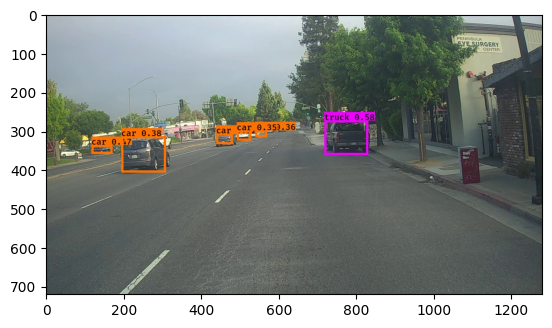

In [28]:
out_scores, out_boxes, out_classes = predict_image("img6.jpg")

## Implementing a Gradio GUI:

In [24]:
def predict_gradio_image(input_image, progress = gr.Progress()):
    """
    Processes an image to predict bounding boxes, return detection_summary and output_image to plot themon the Gradio GUI.
    
    Arguments:
    input_image -- numpy array representing an image without bounding boxes.

    Returns:
    output_image -- PIL Image object with bounding boxes drawn.
    detection_summary -- String summarizing the detections.
    """
    progress(0, desc="Starting")
    output_image = Image.fromarray(input_image)
    output_image, image_data = preprocess_image_2(output_image, model_image_size=(608, 608))
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    out_scores, out_boxes, out_classes = evaluate_yolo(yolo_outputs, [output_image.size[1], output_image.size[0]], 10, 0.3, 0.5)
    detection_summary = 'Found {} boxes :\n'.format(len(out_boxes))
    detection_summary += draw_boxes(output_image, out_boxes, out_classes, class_names, out_scores)[-1]
    progress(1)
    return output_image, detection_summary

    

In [25]:
imagein = gr.Image(label= "Input image")
imageout = gr.Image(label= "Output image with boxes")
coordinates_out = gr.Text(label= "Founded boxes")

In [29]:
sample_images = [
                 ["images/img1.jpg"],
                 ["images/img2.jpg"],
                 ["images/img3.jpg"],
                 ["images/img4.jpg"],
                 ["images/img5.jpg"],
                 ["images/img6.jpg"]

]

In [30]:
gr.Interface(
    predict_gradio_image,
    imagein,
    [imageout, coordinates_out],  
    title="Vehicles and Traffic Signs Detection",
    examples=sample_images
).launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


truck 0.58 (718, 273) (831, 362)
car 0.52 (439, 307) (482, 334)
car 0.47 (117, 336) (171, 359)
car 0.38 (194, 314) (309, 407)
car 0.36 (540, 298) (570, 316)
car 0.35 (492, 299) (529, 325)


Traceback (most recent call last):
  File "c:\Users\mkhf2545\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 532, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mkhf2545\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mkhf2545\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1928, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mkhf2545\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1514, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mkhf2545\AppData\Local\Programs\Python\Py

car 0.76 (518, 282) (689, 336)
car 0.72 (883, 260) (1026, 303)
car 0.67 (15, 313) (128, 362)
car 0.64 (741, 266) (918, 313)
car 0.64 (207, 297) (338, 340)
car 0.49 (1256, 253) (1280, 310)
traffic light 0.40 (412, 182) (426, 209)
fire hydrant 0.36 (1055, 411) (1133, 526)
traffic light 0.34 (0, 97) (20, 154)
